## Loading and prepping a video

The optimal file format for diff_classifier is tiff images. Diff_classifier is also optimized to work with data stored in S3 buckets using Amazon Web Services (S3). However, as long as the image is available locally, all functions except the Cloudknot parallelization functions will work. In this small example that doesn't require parallelization, we will use an example file available in the TrackMate documentation bypassing the need to interface with S3.

In [ ]:
import skimage.io as sio
import os

filename = 'http://fiji.sc/samples/FakeTracks.tif'
testim = sio.imread(filename)
sio.imsave('FakeTracks.tif', testim)
nframes = testim.shape[0]

This interactive widget allows the user to check the video prior to tracking analysis.

In [2]:
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def update(w, vmin=5, vmax=300):
    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(testim[w, :, :], cmap='gray', vmin=vmin, vmax=vmax)
    ax.axis('off')
    
widgets.interact(update, w=(0, 49, 1), vmin=(0, 100, 1), vmax=(10, 500, 1));

interactive(children=(IntSlider(value=24, description='w', max=49), IntSlider(value=5, description='vmin'), IntSlider(value=300, description='vmax', max=500, min=10), Output()), _dom_classes=('widget-interact',))

## Particle tracking with Trackmate

In [3]:
import diff_classifier.imagej as ij

name = 'FakeTracks'
filename1 = '{}/{}.tif'.format(os.getcwd(), name)
outfile = 'Traj_{}.csv'.format(name)

Diff_classifier performs tracking analysis with a headless version (no GUI interaction needed) of the ImageJ plugin TrackMate. Fiji must be installed for for successful tracking analysis. See documentation for details. 

As the tracking analysis is performed without the GUI interface, users must already have an idea of what ideal tracking parameters are. It is recommended that users use the TrackMate GUI if only a handful of videos are to be analyzed. When large numbers of videos are being processed, then the parallelization tools presented in the other demo notebooks become useful. This video is analyzed with the diff_classifier track function just to demo how it works.

In [4]:
tparams = {'frames': nframes, 'radius': 3.5, 'threshold': 0.0, 'do_median_filtering': False,
           'quality': 3.0, 'xdims': (0, 128), 'ydims': (1, 128),
           'median_intensity': 300.0, 'snr': 0.0, 'linking_max_distance': 15.0,
           'gap_closing_max_distance': 15.0, 'max_frame_gap': 7,
           'track_duration': 5.0}

**Note: This code will not run unless Fiji is properly installed.** 

If `fiji_bin` is set to `None`, default behavior for a Linux system is to look in `~/Fiji.app/`. 

In [5]:
ij.track(filename1, outfile, template=None, fiji_bin=None, tparams=tparams)
print("Done with tracking.  Should output file of name {}".format(outfile))

/home/ubuntu/Fiji.app/ImageJ-linux64 --ij2 --headless --run /tmp/tmpid9b2hfn.py
Done with tracking.  Should output file of name Traj_FakeTracks.csv


## Calculate features and MSDs

Downstream functions calculate mean squared displacements and trajectory features for further analysis

In [6]:
import diff_classifier.utils as ut
import diff_classifier.msd as msd
import diff_classifier.features as ft
import diff_classifier.heatmaps as hm

traj = ut.csv_to_pd(outfile)
msd_file = 'msd_{}.csv'.format(name)
ft_file = 'features_{}.csv'.format(name)

In [7]:
msds = msd.all_msds2(traj, frames=50)
msds.to_csv(msd_file)
feat = ft.calculate_features(msds)
feat.to_csv(ft_file)

Plotted FakeTracks trajectories successfully.


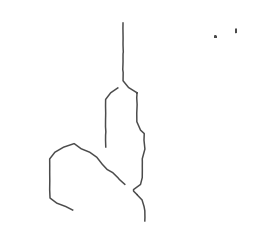

In [8]:
hm.plot_trajectories(name, resolution=128, rows=1, cols=1, upload=False, figsize=(4, 4))

In [9]:
def update(frame):
    particles = int(max(traj['Track_ID']))
    for part in range(0, particles):
        x = traj[traj['Track_ID'] == part].sort_values(by=['Frame'])['X']
        y = traj[traj['Track_ID'] == part].sort_values(by=['Frame'])['Y']
        plt.plot(x[0:frame], y[0:frame], color='k', alpha=0.7)
    plt.xlim(0, 128)
    plt.ylim(0, 128)
    plt.axis('off')
    
widgets.interact(update, frame=(0, 49, 1))

interactive(children=(IntSlider(value=24, description='frame', max=49), Output()), _dom_classes=('widget-interact',))

<function __main__.update>

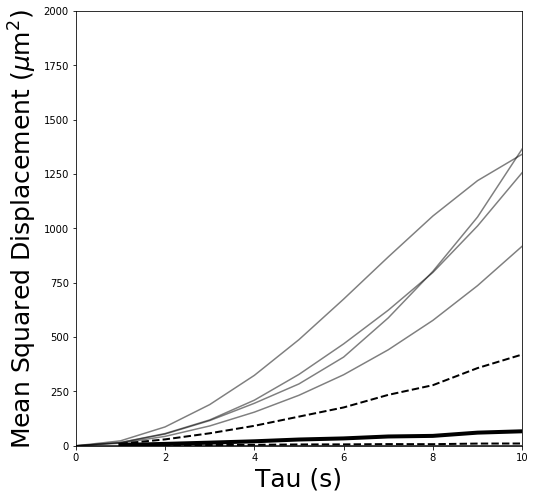

In [10]:
geomean, gSEM = hm.plot_individual_msds(name, x_range=10, y_range=2000, umppx=1, fps=1, alpha=0.5, upload=False, figsize=(8, 8))